# Traveling Salesperson on Dirac
#### Device: Dirac-1

## Introduction

The traveling salesperson problem is a longstanding example of the difficulty found in solving combinatorial problems. The typical problem statement is that a list of cities must all be visited, but one can do so in any order. A list of distances between cities is provided, and the goal is to find the order that minimises them. Despite the simple explanation of the problem, a polynomial-time solution is not known to exist. This example takes 16 random points on the upper right quadrant $(30, 30)$ of the Cartesian plane, calculates the Euclidian distance between them, and formulates a sequential model (visit node $x_i$ first, node $x_j$ second and so forth ).

## Importance

The traveling salesperson problem is often used as a stereotypical example of a hard opimisation problem, it is easy to understand how such a problem arises, the statement is simple and non-technical, and the constraints are easy to understand. Sometimes people even informally use it as a shorthand for all hard combinatorial optimisation problems, referring to NP-hard problems as "travelling salesperson type problems". When formally stating the constraints of the travelling salesperson problem, the best formulation is not to directly constrain "visit each city at least once" instead the constraints are formally that $n$ cities have to be visited and each can be visited only once. Since distances between cities are positive, returning to the same city multiple times is clearly sub-optimal and therefore such routes do not need to be included among the possibilities (note that it is perfectly possible that the shortest route goes *through* another city, but this case does not need an special treatment). The second constraint is one which is physically obvious but still needs to be explicitly encoded: the salesperson can only be in once city at a time. The constraint structure is therefore what is called a double-one-hot structure, variables correspond to visiting a city at a certain time in the tour, if we arrange these in rows (corresponding to cities) and columns (corresoponding to times), the sum of each row and column must be one. Since it involes constraints, we format the travelling salesperson problem as a [quadratic linearly constrained binary optimisation](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/quadratic-linearly-constrained-binary-optimization) problem. This constraint pattern can be found in other problems as well, for example the [quadratic assignment problem](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qap-tutorial). 

## Applications
The most obvious application of this problem can be deduced from the name, imagine a door-to-door salesperson who has to visit a set of city to sell goods. The order is not important, but every city must be visited, on the other hand, the salesperson has to buy fuel and spend time driving so wants to minimise the distance. This stereotypical application has even made it into popular culture, and for example is referenced in [xkcd 399](https://xkcd.com/399). One can also imagine many situations in logistics where the same problem could arise, for example if a driver were making deliveries or picking items up instead of selling products.
Less obvious examples are summarised in [this book](https://core.ac.uk/download/478116421.pdf). For example, this problem can also arise in manufacturing, when holes must be drilled in a board, but can be done so in any order, similarly if a circuit is to be wired with connected pins, but only two wires are allowed to connect to each. A completely different example comes up in x-ray crystallography a single sensor often must be moved to measure at different places, but the measurements can be taken in any order.

## Qatalyst

### I. Imports

These imports bring in various libraries and modules for different functionalities, such as: 
- `os.path`: Provides functions for working with file paths.
- `numpy as np`: Numerical computing library for arrays and mathematical operations.
- `matplotlib.pyplot as plt`: Plotting library for creating visualizations.
- `QciClient from qci_client`: Client class for interacting with an external service.
- `create_qap_objective, create_qap_constraints from helpers`: Functions for creating QAP objectives and constraints.

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
from qci_client import QciClient
from helpers import create_qap_objective, create_qap_constraints

### II. Plot of random points

- Visualize the set up of the initial conditions for solving the TSP by generating city coordinates.

In [2]:
n = 8
np.random.seed(n)
coords = np.random.randint(1, 30, (n, 2))

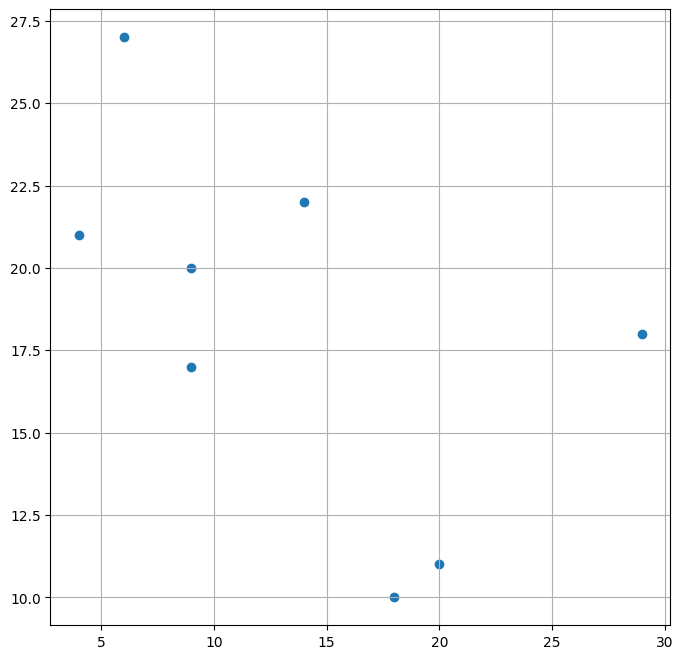

In [3]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(coords[:,0], coords[:, 1])
plt.grid()

### III. Problem formulation

`tsp_objective`, below, computes the components of the objective function for the Traveling Salesman Problem (TSP) based on the given distance matrix. The components are components of quadratic assignment problems, tailored towards TSP.

- Input: `distance_matrix` is a square matrix representing the distances between various locations (nodes) in the TSP.

- Output: The function returns three components of the TSP objective function:

    1. Distance Matrix (`D`): This matrix represents the distances between locations. It's essentially a copy of the input `distance_matrix`.

    2. Flow Matrix (`flow`): This matrix represents the flow or connections between locations. It's a diagonal matrix with ones along the secondary diagonal and one additional one to close the loop (from the last node back to the first).

    3. Fixed Cost Matrix (`fixed_cost`): This matrix represents fixed costs associated with visiting each location. The first row indicates the fixed cost for each location, and it's set to 4 for all locations except the first (which is set to 0). The values are then normalized so that their sum equals the average cost per location.
    
These components are used to formulate the objective function for optimization algorithms solving the TSP.

In [4]:
def tsp_objective(distance_matrix):
    n = distance_matrix.shape[0]
    D = distance_matrix
    flow = np.diag(np.ones(n-1), 1)
    flow[n-1, 0] = 1
    fixed_cost = np.zeros((n, n))
    fixed_cost[0, :] = 4 * np.ones(n)
    fixed_cost[0, 0] = 0.0
    fixed_cost /= (np.sum(fixed_cost) / n)
    return D, flow, fixed_cost

Compute the pairwise distances between each pair of coordinates to be used in the Traveling Salesman Problem (TSP).

In [5]:
def dist(coord1, coord2):
    return np.sqrt(np.sum(np.power(coord1-coord2, 2), axis=1))

distance_matrix = np.zeros((n, n))
for i in range(n):
    distance_matrix[i,:] = dist(coords, coords[i])

After constructing and returning the objective function for the TSP, create files containing constraints and objectives for a QAP-like optimization problem based on the TSP objective, using the computed distance matrix.

In [6]:
A, B, C = tsp_objective(distance_matrix)

In [7]:
constraint_file = create_qap_constraints(n)
obj_file = create_qap_objective(A, B, C, n, n**2)

### IV. Instantiate client, pass job parameters, and execute
- Requirement: `QciClient` client token
- Preliminary: Use `upload_file()` of `QciClient` class instance to upload problem and retrieve `objective_file_id` and `constraints_file_id` of objective and constraints objects
- Next: Pass `objective_file_id` and `constraints_file_id`, alongside with additional job body parameters (defined below), to request body call, `build_job_body()` of `QciClient` class
- Last: Execute job with `process_job()` of `QciClient` class instance

**Client authentication**

Set up a client for interacting with the QCi (Quantum Computing Inc.) API. Here's a breakdown of each client parameter and the client object:

- `api_token`: This variable stores the authentication token required to access the QCi API. Authentication tokens are obtained by registering an account with the service and generating an API token through QCi's authentication portal.

- `url`: This variable holds the base URL of the QCi API. It specifies the endpoint where API requests will be sent. The URL provided (`https://api.qci-prod.com`) points to the production environment of the QCi API.

- `client`: This variable represents the `QciClient` object, which is an instance of a class used to interact with the QCi API. The `QciClient` class contains methods and functions that allow users to perform various actions, such as submitting quantum computing tasks, retrieving results, and more.

In [8]:
url = "https://api.qci-prod.com"
client = QciClient(api_token=os.getenv("QCI_TOKEN"), url=url)

**Upload**

Upload files to server using Qatalyst's client object (`client`). Here's a breakdown:

1. **Upload Objective File**: The `upload_file` method of the `client` object is called with `obj_file` as an argument. This uploads the objective file containing objective data and specifications to the server. The result of this operation is a file response object that contains an identifier associated with the uploaded objective file. This file ID is stored in the variable `obj_file_id`, which will be used for specification in the job request body (below).

2. **Upload Constraint File**: Similarly, the `upload_file` method is called again with `constraint_file` as an argument, indicating the upload of a file containing constraint data and specifications to the server. As with the objective file, the result of this operation is a file response object that contains a file ID associated with the uploaded constraint file, which is stored in the variable `constraint_file_id` (for specification in the job request body).

In [9]:
obj_file_id = client.upload_file(obj_file)["file_id"]
constraint_file_id = client.upload_file(constraint_file)["file_id"]

**Client job body and execution**

1. **Build Job Body**: The `build_job_body` method of the `client` object is called with several parameters:
    - `job_type`: Specifies the type of job to be created; `"sample-constraint"` in this case.
    - `objective_file_id`: Provides the file ID of the objective file uploaded earlier.
    - `constraints_file_id`: Provides the file ID of the constraint file uploaded earlier.
    - `job_params`: Additional parameters related to the job, such as the sampler type (`"dirac-1"`), the number of samples (`"nsamples": 5`), and an alpha value (`"alpha": 20`). These parameters customize the behavior of the job.
2. **Process Job**: Once the job body is constructed, the `process_job` method of the `client` object is called with the following parameters:
    - `job_type`: Specifies the type of job to be processed, which matches the job type used when building the job body (`"sample-constraint"`).
    - `job_body`: Provides the job body constructed earlier, containing all the necessary information and parameters for the job.

The `process_job` method sends the job request to the API for processing, and the response variable holds the response returned by the API, which contains information about the status and results of the job processing.

In [10]:
job_body = client.build_job_body(job_type="sample-constraint", objective_file_id=obj_file_id, 
                                 constraints_file_id=constraint_file_id, job_params={
                                     "sampler_type": "dirac-1",
                                     "nsamples": 5, 
                                     "alpha": 20
                                 })

response = client.process_job(job_type="sample-constraint", job_body=job_body)

Dirac allocation balance = 0 s (unmetered)
Job submitted job_id='65f85630a657b4e45963cd70'-: 2024/03/18 10:56:47
RUNNING: 2024/03/18 10:56:49
COMPLETED: 2024/03/18 10:57:00
Dirac allocation balance = 0 s (unmetered)


In [13]:
results = response["results"]["file_config"]["quadratic_linearly_constrained_binary_optimization_results"]
results

{'counts': [1],
 'energies': [-252.56494140625],
 'feasibilities': [True],
 'objective_values': [67.4352263212204],
 'solutions': [[0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0]]}

### V. Evaluate solution

Visualization of a route based on a given solution to the Traveling Salesman Problem (TSP).

In [12]:
def plot_route(coords, solution, N):
    pairs = []
    order = [None for i in range(N)]
    for i in range(N):
        for j in range(N):
            if solution[i*N + j] == 1:
                order[j] = i
    for i in range(N):
        u = order[i-1]
        v = order[i]
        if u is None or v is None:
            continue
        pt1 = coords[u, :]
        pt2 = coords[v, :]
        x = [pt1[0], pt2[0]]
        y = [pt1[1], pt2[1]]
        plt.plot(x, y, "r-")
    plt.scatter(coords[:,0], coords[:, 1], c="k", marker="o")

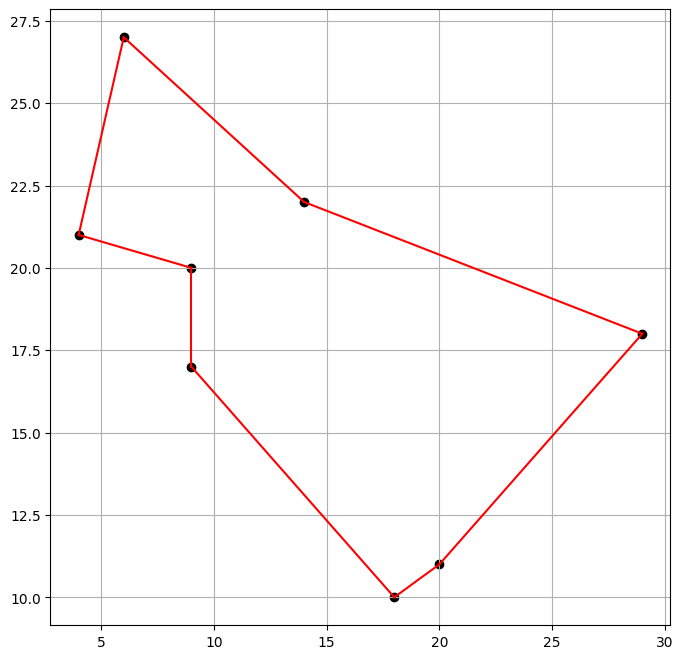

In [18]:
fig = plt.figure(figsize=(8, 8))
plot_route(coords, results["solutions"][0], n)
plt.grid()

## Conclusion

In this tutorial we have shown how to use our hardware for one of the most stereotypical NP-hard optimisation problem, the traveling salesperson problem. We constructed a simple map which assumes travel in a streight line between randomly assigned cities and have visualised the result. A good next step could be to look at the [quadratic assignment problem](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/qap-tutorial), which uses the same constraint structure, or to explore other, constrained problems which are device can solve through the [quadratic linearly constrained binary optimisation](https://quantumcomputinginc.com/learn/tutorials-and-use-cases/quadratic-linearly-constrained-binary-optimization) page. Of course another option is to start using our device to solve some of your own optimisation problems.